# Porsche's EV Offering
## Where to start?

This notebook is a compilation of the exploratory and statistical analysis of the [income tax data](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2017-zip-code-data-soi) in the states with growing demand for electric vehicles and charging stations.

In [1]:
%matplotlib inline
from __future__ import print_function

import warnings
import itertools
import numpy as np
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')

import geopandas as gpd
from shapely.geometry import Point, Polygon
from descartes import PolygonPatch

# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

PROJ_ROOT = os.pardir

## Importing Data

Income tax data by zip code from 2017 is imported into a dataframe from a csv file. Data wrangling is performed to remove unnecessary columns and rows, rename the columns, and format the values.

In [2]:
tax_data_path = os.path.join(PROJ_ROOT, "data", "raw", "IncomeTax2017.csv")
tax = pd.read_csv(tax_data_path)

In [3]:
tax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166537 entries, 0 to 166536
Columns: 153 entries, STATEFIPS to A12000
dtypes: float64(149), int64(3), object(1)
memory usage: 194.4+ MB


In [4]:
tax.columns

Index(['STATEFIPS', 'STATE', 'zipcode', 'agi_stub', 'N1', 'mars1', 'MARS2', 'MARS4', 'ELF', 'CPREP',
       ...
       'N85300', 'A85300', 'N11901', 'A11901', 'N11900', 'A11900', 'N11902', 'A11902', 'N12000', 'A12000'], dtype='object', length=153)

In [5]:
tax.head()

,STATEFIPS,STATE,zipcode,agi_stub,N1,mars1,MARS2,MARS4,ELF,CPREP,PREP,DIR_DEP,N2,NUMDEP,TOTAL_VITA,VITA,TCE,VITA_EIC,RAC,ELDERLY,A00100,N02650,A02650,N00200,A00200,N00300,A00300,N00600,A00600,N00650,A00650,N00700,A00700,N00900,A00900,N01000,A01000,N01400,A01400,N01700,A01700,SCHF,N02300,A02300,N02500,A02500,N26270,A26270,N02900,A02900,N03220,A03220,N03300,A03300,N03270,A03270,N03150,A03150,N03210,A03210,N03230,A03230,N03240,A03240,N04470,A04470,A00101,N17000,A17000,N18425,A18425,N18450,A18450,N18500,A18500,N18800,A18800,N18300,A18300,N19300,A19300,N19500,A19500,N19530,A19530,N19550,A19550,N19570,A19570,N19700,A19700,N20800,A20800,N20950,A20950,N04800,A04800,N05800,A05800,N09600,A09600,N05780,A05780,N07100,A07100,N07300,A07300,N07180,A07180,N07230,A07230,N07240,A07240,N07220,A07220,N07260,A07260,N09400,A09400,N85770,A85770,N85775,A85775,N09750,A09750,N10600,A10600,N59660,A59660,N59720,A59720,N11070,A11070,N10960,A10960,N11560,A11560,N06500,A06500,N10300,A10300,N85530,A85530,N85300,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000
0,1,AL,0,1,802640.0,474470.0,99850.0,216600.0,717050.0,44090.0,426090.0,580390.0,1259760.0,475750.0,25570.0,17310.0,8250.0,5670.0,212170.0,150660.0,10467448.0,802640.0,10626881.0,640460.0,8368271.0,89770.0,54949.0,40190.0,67982.0,35970.0,45716.0,8330.0,4383.0,144200.0,741047.0,33800.0,35843.0,37360.0,236386.0,102180.0,1006563.0,7520.0,19890.0,55501.0,37230.0,71438.0,7620.0,14770.0,139300.0,159433.0,1020.0,236.0,20.0,322.0,7430.0,27950.0,1420.0,4577.0,16550.0,14416.0,3020.0,8500.0,0.0,0.0,47630.0,689818.0,751809.0,34130.0,273863.0,17870.0,19005.0,21980.0,19378.0,21250.0,20714.0,23730.0,5566.0,45740.0,74501.0,19200.0,100217.0,100.0,368.0,270.0,99.0,1030.0,1231.0,110.0,105.0,35200.0,103351.0,17790.0,87398.0,610.0,3634.0,320210.0,1810199.0,323470.0,195040.0,0.0,0.0,15860.0,5991.0,97510.0,32768.0,1910.0,64.0,6350.0,2134.0,26120.0,14213.0,32440.0,5581.0,27250.0,8374.0,870.0,483.0,112110.0,153786.0,54300.0,390448.0,56390.0,397723.0,14430.0,8483.0,741920.0,2078353.0,353820.0,1078908.0,324630.0,967560.0,221720.0,283322.0,55630.0,51730.0,23200.0,14464.0,255600.0,161796.0,363870.0,327165.0,0.0,0.0,0.0,0.0,64680.0,53602.0,700940.0,1803125.0,698100.0,1796343.0,2860.0,4917.0
1,1,AL,0,2,499070.0,218590.0,137460.0,129760.0,448190.0,26230.0,269560.0,365010.0,985860.0,352150.0,11550.0,7570.0,3980.0,370.0,120760.0,112510.0,17977581.0,499070.0,18153235.0,429020.0,14801613.0,90100.0,62310.0,39370.0,91981.0,34800.0,64670.0,41160.0,23705.0,67150.0,254049.0,31780.0,77816.0,36500.0,356129.0,99740.0,1814649.0,9200.0,12930.0,37052.0,92470.0,621873.0,10390.0,66891.0,95290.0,175654.0,12230.0,2973.0,130.0,1219.0,6690.0,32412.0,6750.0,23526.0,41460.0,42786.0,1230.0,3051.0,110.0,549.0,102820.0,1596275.0,3915243.0,53070.0,373900.0,73680.0,126196.0,26840.0,35662.0,63690.0,56781.0,62510.0,17360.0,102190.0,243914.0,58050.0,294335.0,740.0,2605.0,1020.0,553.0,8960.0,10704.0,330.0,379.0,85170.0,346874.0,44430.0,296676.0,2710.0,17742.0,479010.0,8869988.0,477160.0,1084168.0,0.0,0.0,16720.0,14014.0,212630.0,188236.0,6380.0,324.0,31040.0,17420.0,42010.0,43477.0,80740.0,15341.0,120230.0,106522.0,7380.0,6388.0,38700.0,86925.0,27970.0,188902.0,29050.0,201292.0,18970.0,13043.0,487380.0,2065629.0,138510.0,295395.0,115390.0,249017.0,100530.0,139491.0,31740.0,28933.0,6510.0,6541.0,380780.0,896996.0,401700.0,1003316.0,0.0,0.0,0.0,0.0,77660.0,118725.0,419640.0,1175607.0,416180.0,1165352.0,4250.0,8894.0
2,1,AL,0,3,268590.0,89780.0,134440.0,38280.0,241060.0,14160.0,156410.0,175150.0,584720.0,181950.0,2780.0,1430.0,1350.0,0.0,44750.0,78030.0,16502473.0,268590.0,16659518.0,229300.0,12727137.0,82080.0,64795.0,38570.0,122427.0,35410.0,88866.0,54360.0,37829.0,41690.0,266422.0,32780.0,121012.0,30100.0,402312.0,72260.0,1832668.0,8980.0,6000.0,19864.0,65050.0,989915.0,11000.0,136620.0,69600.0,157045.0,9450.0,2406.0,120.0,1088.0,5540.0,36381.0,5310.0,23467.0,29700.0,32739.0,1400.0,2974.0,130.0,1287.0,101900.0,1784599.0,6349051.0,35630.0,274239.0,81640

In [6]:
# Define new dataframe and rename the necessary columns from tax data
df = pd.DataFrame({'State':tax.STATE,
                  'ZipCode':tax.zipcode,
                  'AGIRange':tax.agi_stub,
                  'AGI':tax.A00100,
                  'NumberofReturns':tax.N1,
                  'Single':tax.mars1,
                  'Joint':tax.MARS2,
                  'Dependents':tax.NUMDEP,
                  'Elderly':tax.ELDERLY,
                  'Farm':tax.SCHF,
                  'SCorp':tax.N26270})
df.head()

,State,ZipCode,AGIRange,AGI,NumberofReturns,Single,Joint,Dependents,Elderly,Farm,SCorp
0,AL,0,1,10467448.0,802640.0,474470.0,99850.0,475750.0,150660.0,7520.0,7620.0
1,AL,0,2,17977581.0,499070.0,218590.0,137460.0,352150.0,112510.0,9200.0,10390.0
2,AL,0,3,16502473.0,268590.0,89780.0,134440.0,181950.0,78030.0,8980.0,11000.0
3,AL,0,4,14817087.0,170880.0,32180.0,124070.0,130670.0,53770.0,5140.0,8810.0
4,AL,0,5,31131390.0,229870.0,22810.0,196990.0,204340.0,74020.0,8790.0,25400.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166537 entries, 0 to 166536
Data columns (total 11 columns):
State              166537 non-null object
ZipCode            166537 non-null int64
AGIRange           166537 non-null int64
AGI                166537 non-null float64
NumberofReturns    166537 non-null float64
Single             166537 non-null float64
Joint              166537 non-null float64
Dependents         166537 non-null float64
Elderly            166537 non-null float64
Farm               166537 non-null float64
SCorp              166537 non-null float64
dtypes: float64(8), int64(2), object(1)
memory usage: 14.0+ MB


In [8]:
# Remove rows where ZipCode is 0 or 99999
df = df[df['ZipCode'] != 0]
df = df[df['ZipCode']!=99999]
df = df.reset_index(drop=True)
df.head()

,State,ZipCode,AGIRange,AGI,NumberofReturns,Single,Joint,Dependents,Elderly,Farm,SCorp
0,AL,35004,1,19889.0,1500.0,970.0,220.0,700.0,360.0,0.0,20.0
1,AL,35004,2,50071.0,1340.0,670.0,350.0,790.0,270.0,0.0,20.0
2,AL,35004,3,56574.0,920.0,330.0,430.0,630.0,200.0,0.0,30.0
3,AL,35004,4,55894.0,650.0,110.0,480.0,540.0,130.0,0.0,30.0
4,AL,35004,5,84707.0,650.0,60.0,570.0,640.0,140.0,0.0,30.0


In [9]:
# Get the income tax data for the high potential states of Oklahoma and North Dakota
high_potential_states = pd.concat([df[df['State'] == 'OK'],df[df['State'] == 'ND']])

## Exploratory Data Analysis

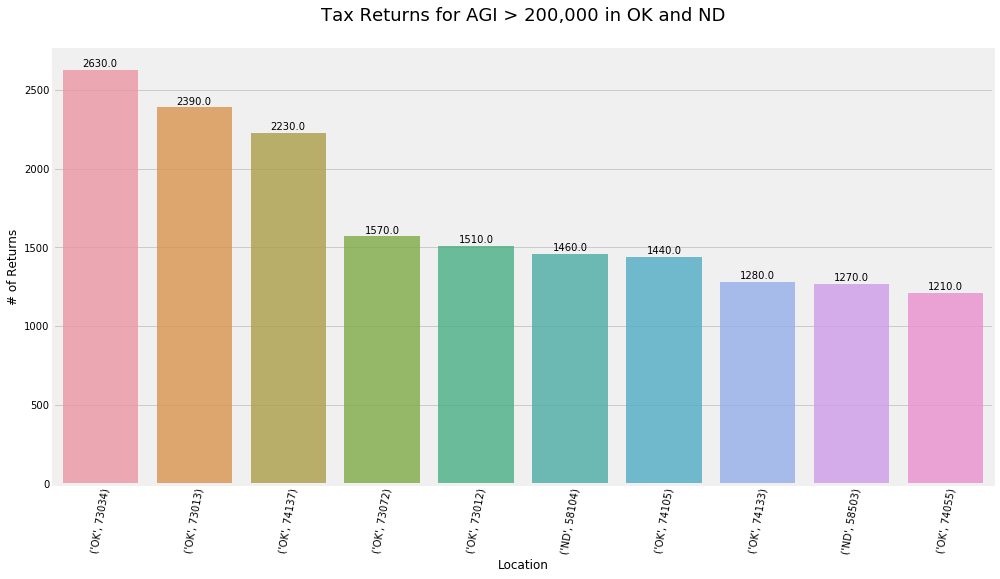

<Figure size 432x288 with 0 Axes>

In [10]:
# Get the number of returns for AGI above 200,000 in high potential states
x1 = high_potential_states[high_potential_states['AGIRange']>5].groupby(['State','ZipCode']).NumberofReturns.sum().sort_values(ascending=False)
x1 = x1[:10]

# Plot the top 10 zip codes with number of returns for AGI greater than 200,000 ranked in descending order
plt.figure(figsize=(15,8))
ax = sns.barplot(x1.index, x1.values, alpha=0.8)
plt.title("Tax Returns for AGI > 200,000 in OK and ND",fontsize=18,y=1.05)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# of Returns', fontsize=12)
plt.xlabel('Location', fontsize=12)

# Add text labels of the number of returns above the bars in the plot.
rects = ax.patches
labels = x1.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()
plt.savefig('ok_nd_tax.png');

Visual analysis of the number of returns for adjusted gross income above 200,000 in Oklahoma and North Dakota reveals the zip codes with the most number of high AGI returns. 8 out of the top 10 locations with many high AGI tax returns are in Oklahoma. Combined with Oklahoma's high EV sales and market share increase from 2017 to 2018 and its low charging station count, the state is an ideal candidate for Porsche to invest in charging infrastructure and to roll out an EV offering strategy.

In [11]:
# Import data for stations in Oklahoma
ok_data_path = os.path.join(PROJ_ROOT, "data", "raw", "ok_stations.csv")
ok_stations = pd.read_csv(ok_data_path)

In [12]:
# Group the stations in Oklahoma by zip code and count the number
x2 = ok_stations.groupby('ZIP')['State'].value_counts().sort_values(ascending=False)
x2 = x2[:10]
x2

ZIP    State
74103  OK       7
73034  OK       7
73401  OK       5
73099  OK       4
74074  OK       4
74119  OK       4
74133  OK       3
73072  OK       3
73036  OK       3
73102  OK       3
Name: State, dtype: int64

In [13]:
# Import sales and stations for all states with growing demand for EV and charging stations
growth_data_path = os.path.join(PROJ_ROOT, "data", "processed", "growth_states.csv")
growth_states = pd.read_csv(growth_data_path)

# Get the income tax data of the growth states
growth = df[df['State'].isin(growth_states.StateCode)]

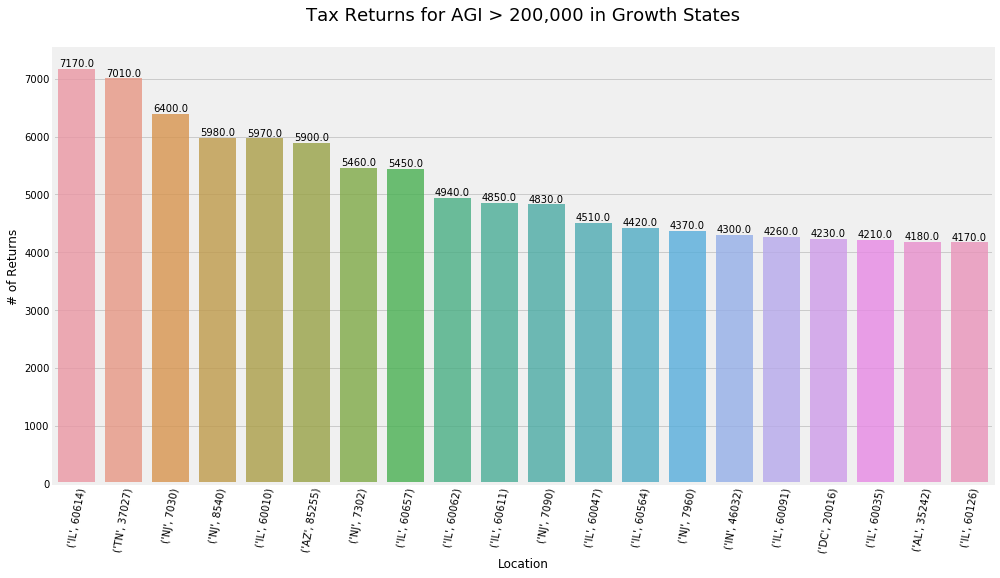

<Figure size 432x288 with 0 Axes>

In [14]:
# Get the number of returns for AGI above 200,000 in growth states
x3 = growth[growth['AGIRange']==6].groupby(['State','ZipCode']).NumberofReturns.sum().sort_values(ascending=False)
x3 = x3[:20]

# Plot the top 20 zip codes with number of returns for AGI greater than 200,000 ranked in descending order
plt.figure(figsize=(15,8))
ax = sns.barplot(x3.index, x3.values, alpha=0.8)
plt.title("Tax Returns for AGI > 200,000 in Growth States",fontsize=18,y=1.05)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# of Returns', fontsize=12)
plt.xlabel('Location', fontsize=12)

# Add text labels of the number of returns above the bars in the plot.
rects = ax.patches
labels = x3.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()
plt.savefig('growth_tax.png');

Out of all the states with growing demand for EV and charging stations, Illinois and New Jersey have the most locations with many high AGI tax returns. Chicago comes in first for the most number of returns. These locations have the most consumers who can afford electric vehicles in the price range of a Porsche Taycan.

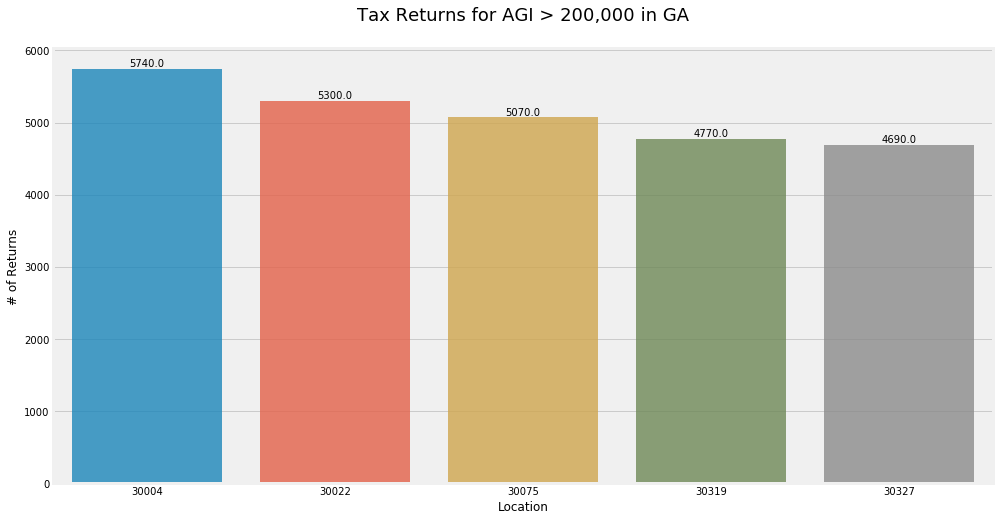

<Figure size 432x288 with 0 Axes>

In [15]:
# Get the number of returns for AGI above 200,000 in Georgia
ga = df[df['State'] == 'GA']
x4 = ga[ga['AGIRange']>5].groupby(['ZipCode']).NumberofReturns.sum().sort_values(ascending=False)
x4 = x4[:5]

# Plot the top 10 zip codes with number of returns for AGI greater than 200,000 ranked in descending order
plt.figure(figsize=(15,8))
ax = sns.barplot(x4.index, x4.values, alpha=0.8)
plt.title("Tax Returns for AGI > 200,000 in GA",fontsize=18,y=1.05)
locs, labels = plt.xticks()
plt.setp(labels, rotation=0)
plt.ylabel('# of Returns', fontsize=12)
plt.xlabel('Location', fontsize=12)

# Add text labels of the number of returns above the bars in the plot.
rects = ax.patches
labels = x4.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()
plt.savefig('ga_tax.png');

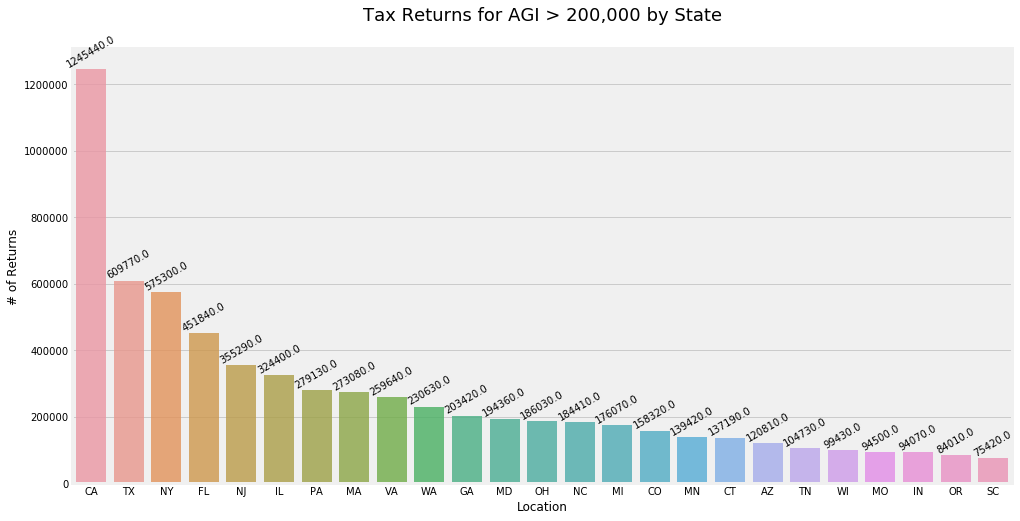

<Figure size 432x288 with 0 Axes>

In [16]:
# Get the total number of returns for AGI above 200,000 for each state
x5 = df[df['AGIRange']==6].groupby(['State']).NumberofReturns.sum().sort_values(ascending=False)
x5 = x5[:25]
# Plot the top 10 zip codes with number of returns for AGI greater than 200,000 ranked in descending order
plt.figure(figsize=(15,8))
ax = sns.barplot(x5.index, x5.values, alpha=0.8)
plt.title("Tax Returns for AGI > 200,000 by State",fontsize=18,y=1.05)
locs, labels = plt.xticks()
plt.setp(labels, rotation=0)
plt.ylabel('# of Returns', fontsize=12)
plt.xlabel('Location', fontsize=12)

# Add text labels of the number of returns above the bars in the plot.
rects = ax.patches
labels = x5.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', rotation=30)

plt.show()
plt.savefig('agi_rank.png');

In [17]:
# Import sales data
sales_data_path = os.path.join(PROJ_ROOT, "data", "processed", "ev_sales.csv")
sales = pd.read_csv(sales_data_path)

# Get the total number of returns for AGI > 200,00 by state and store in sales dataframe
sales['HighAGIReturns'] = df[df['AGIRange']==6].groupby(['State']).NumberofReturns.sum().values
sales.head()

,State,Sales2016,Sales2017,Sales2018,2017SalesIncrease,2018SalesIncrease,MarketShare2017,MarketShare2018,2018ShareIncrease,StationCount,StateCode,Increase,HighAGIReturns
0,Alabama,330,381,866,0.16,1.27,0.0019,0.0041,1.16,136,AL,6.94,13000.0
1,Alaska,94,85,155,-0.10,0.82,0.0037,0.0059,0.59,19,AK,9.20,61010.0
2,Arizona,2265,2976,7086,0.31,1.38,0.0090,0.0184,1.04,466,AZ,3.45,33410.0
3,Arkansas,138,187,435,0.36,1.33,0.0016,0.0035,1.19,84,AR,2.69,120810.0
4,California,73854,94873,153442,0.29,0.62,0.0502,0.0784,0.56,5706,CA,1.14,1245440.0


## AGI vs. EV Sales

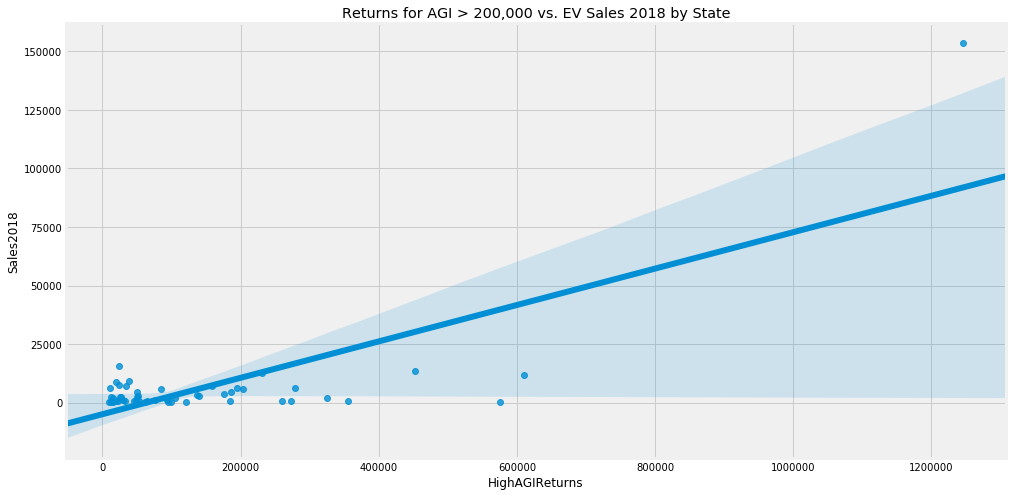

<Figure size 432x288 with 0 Axes>

In [18]:
# Plot number of high AGI returns and EV sales in 2018 by state
plt.figure(figsize=(15,8))
sns.regplot(y='Sales2018',x='HighAGIReturns',data=sales,fit_reg=True).set_title('Returns for AGI > 200,000 vs. EV Sales 2018 by State')
plt.show()
plt.savefig('agi_vs_sales.png');

### Linear Regression
Here,

𝑌  = EV sales for a state (called "target" data in python, and referred to as the dependent variable or response variable)

and

𝑋  = number of returns for AGI > 200,000 for a state and station count (or independent variables, predictors or explanatory variables)

which we will use to fit a linear regression model and predict EV sales. We will use the least-squares method to estimate the coefficients.

In [19]:
# Fit a linear regression model with the ordinary least squares method in statsmodels
m = ols('Sales2018 ~ StationCount + HighAGIReturns', sales).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:              Sales2018   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     328.0
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           1.02e-28
Time:                        14:20:29   Log-Likelihood:                -511.80
No. Observations:                  51   AIC:                             1030.
Df Residuals:                      48   BIC:                             1035.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -5525.4434    974.846     -5.

We can interpret the HighAGIReturns coefficient (0.0064) by first noticing that the p-value (under P>|t|) is 0.29, greater than 0.05. This means that the number of returns for AGI above 200,000 within a state, HighAGIReturns, is not a statistically significant predictor of EV sales. The regression coefficient for HighAGIReturns of 0.0064 means that on average, each additional tax return for AGI above 200,000 is only associated with an increase in sales of 0.6 electric vehicles. The confidence interval gives us a range of plausible values for this average change, about (-1, 2).

AGI statistics within a state is not related to how many electric vehicles can be sold, but station count is.

In [24]:
# Get the total number of returns for AGI >= 75,000 by state and store in sales dataframe
sales['AGI75k+'] = df[df['AGIRange']>=4].groupby(['State']).NumberofReturns.sum().values
sales.head()

,State,Sales2016,Sales2017,Sales2018,2017SalesIncrease,2018SalesIncrease,MarketShare2017,MarketShare2018,2018ShareIncrease,StationCount,StateCode,Increase,HighAGIReturns,AGI75k+
0,Alabama,330,381,866,0.16,1.27,0.0019,0.0041,1.16,136,AL,6.94,13000.0,86940.0
1,Alaska,94,85,155,-0.10,0.82,0.0037,0.0059,0.59,19,AK,9.20,61010.0,456620.0
2,Arizona,2265,2976,7086,0.31,1.38,0.0090,0.0184,1.04,466,AZ,3.45,33410.0,250930.0
3,Arkansas,138,187,435,0.36,1.33,0.0016,0.0035,1.19,84,AR,2.69,120810.0,727940.0
4,California,73854,94873,153442,0.29,0.62,0.0502,0.0784,0.56,5706,CA,1.14,1245440.0,5263240.0


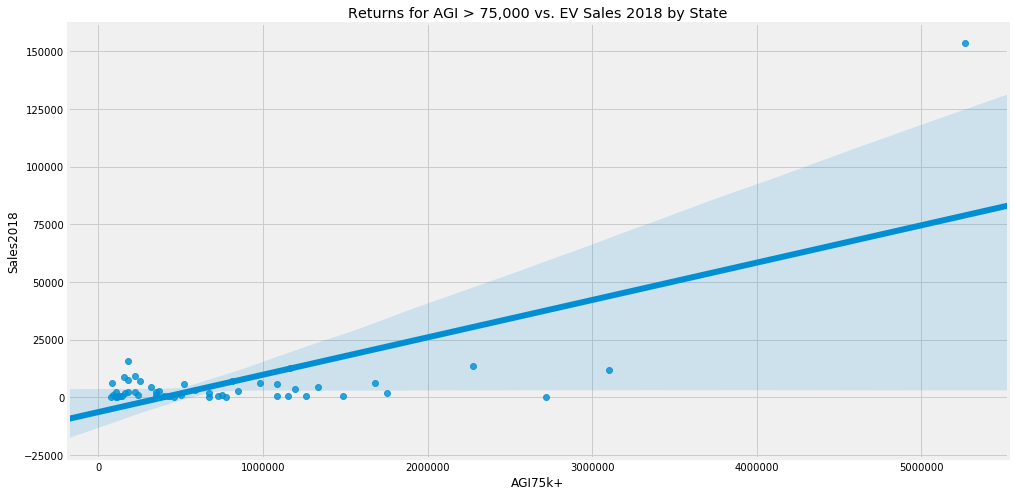

<Figure size 432x288 with 0 Axes>

In [25]:
# Plot number of returns for AGI above 75,000 and EV sales in 2018 by state
plt.figure(figsize=(15,8))
sns.regplot(y='Sales2018',x='AGI75k+',data=sales,fit_reg=True).set_title('Returns for AGI > 75,000 vs. EV Sales 2018 by State')
plt.show()
plt.savefig('agi75k_vs_sales.png');

## To Whom?

In [20]:
# Get tax data for zip codes with over 1000 returns on AGI above 200,000 in Oklahoma
ok = growth[(growth['AGIRange']==6) & (growth['NumberofReturns']>1000) & (growth['State']=='OK')].reset_index(drop=True)
ok.describe()

,ZipCode,AGIRange,AGI,NumberofReturns,Single,Joint,Dependents,Elderly,Farm,SCorp
count,11.000000,11.0,1.100000e+01,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,73529.090909,6.0,8.136270e+05,1614.545455,134.545455,1430.000000,1736.363636,543.636364,41.818182,754.545455
std,556.225935,0.0,2.839045e+05,541.523105,48.448661,519.114631,693.718570,206.168510,19.908883,257.657278
min,73012.000000,6.0,4.676140e+05,1150.000000,50.000000,940.000000,930.000000,280.000000,20.000000,420.000000
25%,73029.500000,6.0,5.984875e+05,1195.000000,115.000000,1090.000000,1290.000000,390.000000,30.000000,570.000000
50%,73120.000000,6.0,7.800890e+05,1440.000000,140.000000,1200.000000,1490.000000,540.000000,30.000000,690.000000
75%,74109.500000,6.0,1.019133e+06,1900.000000,175.000000,1705.000000,2205.000000,675.000000,50.000000,920.000000
max,74137.000000,6.0,1.255393e+06,2630.000000,190.000000,2430.000000,3150.000000,860.000000,80.000000,1160.000000


In [21]:
ok.sum()

State              OKOKOKOKOKOKOKOKOKOKOK
ZipCode                            808820
AGIRange                               66
AGI                            8.9499e+06
NumberofReturns                     17760
Single                               1480
Joint                               15730
Dependents                          19100
Elderly                              5980
Farm                                  460
SCorp                                8300
dtype: object

Out of the 17760 tax returns for AGI above 200,000 in Oklahoma, 15730 of them are joint returns with 19100 claimed dependents and 5980 of them are elderly. The statistics show that of those consumers in Oklahoma who can afford electric vehicles at the price range of Porsche Taycan, most of them are married and almost a third of them are elderly.

In [22]:
# Get tax data for zip codes with over 1000 returns on AGI above 200,000 in Illinois
il = growth[(growth['AGIRange']==6) & (growth['NumberofReturns']>1000) & (growth['State']=='IL')].reset_index(drop=True)
il.sum()

State              ILILILILILILILILILILILILILILILILILILILILILILIL...
ZipCode                                                      5679845
AGIRange                                                         564
AGI                                                      1.20099e+08
NumberofReturns                                               214560
Single                                                         24190
Joint                                                         184000
Dependents                                                    243130
Elderly                                                        57050
Farm                                                             260
SCorp                                                          74190
dtype: object

Out of the 214560 returns for AGI above 200,000 in Illinois, most of them are joint returns, over a quarter of them are elderly, less than 10% of them are single, and at least a third of them are business owners.
The statistics show that of those consumers in Illinois who can afford electric vehicles at the price range of Porsche Taycan, most of them are married, with a significant number of them being elderly and/or business owners.

In [23]:
df.to_csv('income_tax_2017.csv',index=False)
sales.to_csv('state_ev_data.csv',index=False)